<a href="https://colab.research.google.com/github/gzguevara/amex_kaggle/blob/master/Valid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Drive and XGB

In [5]:
from google.colab import drive
drive.mount('/content/drive')

!pip uninstall xgboost
!pip install xgboost

Mounted at /content/drive


# Imports

In [2]:
import pandas as pd
import numpy  as np  

import xgboost as xgb

import sys

import cupy
# for cupu memory managmet
mempool        = cupy.get_default_memory_pool()
pinned_mempool = cupy.get_default_pinned_memory_pool()

# Paths
test_dir    = '/content/drive/MyDrive/KaggleAMEX/Data/test.parquet'
train_dir    = '/content/drive/MyDrive/KaggleAMEX/Data/train.parquet'
model_dir   = '/content/drive/MyDrive/KaggleAMEX/Models'
sub_dir     = '/content/drive/MyDrive/KaggleAMEX/Data/sample_submission.csv'
results_dir = '/content/drive/MyDrive/KaggleAMEX/Results'
freq_dir    = '/content/drive/MyDrive/KaggleAMEX/Data/test/frequency.csv'

#Parameters
SEED, FOLDS = 42, 5


# Read Function

In [3]:
# The following features have been computed earlier in the notebook 'feature_engineering'
def read_test(range, feature_order):

    frequency = pd.read_csv(freq_dir, index_col=0)
    customers = frequency.loc[frequency.frequency.isin(range)].index.values
    
    # num - mean, std, min, max, last, first  cat - last, unique
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/test/base_variables_test.parquet'
    df  = pd.read_parquet(dir)
    df  = df.loc[customers, [x for x in df.columns if x in feature_order]]
    
    # replace categorial
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/test/base_variables_cat_woe_test.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers, [x for x in new.columns if x in feature_order]]
    df[new.columns]  = new
    print('Done base', df.shape)

    # categorial & binary state changes
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/test/state_changes_test.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers, [x for x in new.columns if x in feature_order]]
    df  = pd.concat([new, df], axis=1)
    print('Done state changes', df.shape)
    
    # p_b_s_r_d variables corr and cat/bin sum 
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/test/p_b_s_r_d_test.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers, [x for x in new.columns if x in feature_order]]
    df  = pd.concat([new, df], axis=1)
    print('Done p_b_s_r_d variables', df.shape)
    
    # count na & not na values
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/test/mean_na_test.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers, [x for x in new.columns if x in feature_order]]
    df  = pd.concat([new, df], axis=1)
    print('Done count na variables', df.shape)

    # non linear numerical
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/test/nonlinear_test.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers, [x for x in new.columns if x in feature_order]]
    df  = pd.concat([new, df], axis=1)
    print('Done non linear', df.shape)

    # First & second difference
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/test/diffs_test.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers, [x for x in new.columns if x in feature_order]]
    df  = pd.concat([new, df], axis=1)
    print('Done diff_1 variables', df.shape)
    
    # Sum woe numerical
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/test/num_woe_sum_test.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers, [x for x in new.columns if x in feature_order]]
    df  = pd.concat([new, df], axis=1)
    print('Done sum woe', df.shape)

    # Advanced
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/test/advanced_test.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers, [x for x in new.columns if x in feature_order]]
    df  = pd.concat([new, df], axis=1)
    print('Done advanced features', df.shape)

    return df

In [ ]:
current_test = read_test(list(range(1,14)), features.order.to_list())

# Predict Customer Groups

This loop predicts outcomes based on different models for different groups of customers.

In [ ]:
submission = pd.read_csv(sub_dir)
ranges     = [[1], [2,3,4,5,6,7,8,9,10,11,12], [13]]
model      = xgb.Booster()
frequency  = pd.read_csv(freq_dir, index_col=0)

for freq, cus_range in enumerate(ranges):

    features    = pd.read_csv(f'{model_dir}/freq_{freq+1}/features.csv', index_col=0)
    customers   = frequency.loc[frequency.frequency.isin(cus_range)].index.values
    predictions = pd.DataFrame()

    for model_type in ['avg', 'oof']:

        print('\n', f'freq {freq} model_type {model_type}', '\n')

        feature_order   = features[f'order_{model_type}'].to_list()
        feature_weights = features[f'weights_{model_type}'].to_list()
        
        current_test = read_test(cus_range, feature_order)
        current_test = current_test.reindex(columns=feature_order)
        current_test = xgb.DMatrix(data=np.array(current_test), feature_weights=feature_weights)

        for fold in range(0,FOLDS):
            
            # Load model
            model.load_model(f'{model_dir}/freq_{freq+1}/{model_type}_fold_{fold}.xgb')
            # Make prediction
            cur_preds = model.predict(current_test, iteration_range=(0, model.best_iteration + 1))
            # Append prediction
            predictions[f'type_{model_type}_fold_{fold}'] = cur_preds
        
        # Clean RAM & GPU RAM
        del current_test, cur_preds
            
    submission.loc[customers, 'prediction'] = predictions.median(axis=1).values 

# Predict All Customers

This loop predicts outcomes for customers based on one model

In [ ]:
model       = xgb.Booster()
predictions = pd.DataFrame()
features    = pd.read_csv(f'{model_dir}/all/features.csv', index_col=0)
cus_range   = list(range(1,14))

feature_order   = features[f'order'].to_list()
feature_weights = features[f'weights'].to_list()

current_test = read_test(cus_range, feature_order)
current_test = current_test.reindex(columns=feature_order)

current_test = xgb.DMatrix(data=np.array(current_test), feature_weights=feature_weights)

for model_type in ['avg']:

    for fold in range(0,FOLDS):

        print(f'Predict {model_type} fold {fold}')
        
        # Load model
        model.load_model(f'{model_dir}/all/{model_type}_fold_{fold}.xgb')
        # Make prediction
        cur_preds = model.predict(current_test, iteration_range=(0, model.best_iteration + 1))
        # Append prediction
        predictions[f'type_{model_type}_fold_{fold}'] = cur_preds
      
  

# Create Submission CSV

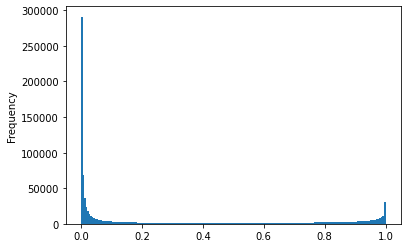

In [19]:
predictions[['type_avg_fold_0',	'type_avg_fold_1', 'type_avg_fold_2', 'type_avg_fold_4']].mean(axis=1).plot(kind='hist', bins=200)

In [16]:
submission = pd.read_csv(sub_dir)

In [61]:
submission.prediction = predictions.prediction_2

In [62]:
# DISPLAY PREDICTIONS
submission.to_csv(f'{results_dir}/submission_xgb.csv',index=False)
submission.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.040339
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001177
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.039301
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.479780
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.904219


In [ ]:
# DISPLAY PREDICTIONS
submission.to_csv(f'{results_dir}/submission_xgb.csv',index=False)
submission.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.039948
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.004983
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.077586
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.506712
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.957867
